#### The goal of this project file is to predict nitrogen, phosphorus, and sediment concentrations at subwatersheds 8, 11, and 12
- so far only completed nitrogen

In [1]:
import pandas as pd
import math
import numpy as np
import sklearn as sk
import sklearn.datasets as skd
import sklearn.ensemble as ske
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

#### Main nutrients dataset

In [2]:
df_main = pd.read_excel('2016-17 raw data.xlsx', sheet_name = 'By subwatershed')
#df_main.head()

In [3]:
df_main = df_main.rename(columns={'Row crop area (%)':'Row crop','Drainage extend (%)':'drain extend',
                                  'Soils with C-D drain classes area (%)':'C-D soils',
                                  'Manure application area (%)':'Manure', 'Nutrient mgmt area (%)':'Nutrient mgmt',
                                  'Cover crop area (%)':'Cover crop','Reduced till area (%)':'Reduced till',
                                  'Terraces area (%)':'Terraces', 'GWW area (%)':'GWW', 'CRP area (%)':'CRP',
                                  'Flow (cms)':'Flow', 'NH3-N (mg N/L)':'NH3','DRP (mg P/L)':'DRP', 'TP (mg P/L)':'TP', 
                                  'NOx-N (mg N/L)':'NOx', 'TN (mg N/L)':'TN', 'TSS (mg/L)':'TSS', 'VSS (mg/L)':'VSS'})

df_main.head()

,Site,Row crop,drain extend,C-D soils,Manure,Nutrient mgmt,Cover crop,Reduced till,Terraces,GWW,...,Sample date,Sample type,Flow,DRP,TP,TSS,VSS,NH3,NOx,TN
0,Sub11,0.93,0.234,0.251,0.543494,0.27256,0.0,0.037315,0.000823,0.044298,...,2016-03-31,Base,0.025511,0.001,0.293,18.666667,14.000000,0.022,35.3001,34.2560
1,Sub11,0.93,0.234,0.251,0.543494,0.27256,0.0,0.037315,0.000823,0.044298,...,2016-04-14,Base,0.041794,0.013,0.040,2.000000,3.333333,0.002,31.7656,31.7656
2,Sub11,0.93,0.234,0.251,0.543494,0.27256,0.0,0.037315,0.000823,0.044298,...,2016-04-28,Base,0.078278,0.001,0.129,39.333333,31.333333,0.002,30.5188,30.3610
3,Sub11,0.93,0.234,0.251,0.543494,0.27256,0.0,0.037315,0.000823,0.044298,...,2016-05-17,Base,0.064980,0.001,0.177,63.333333,37.333333,0.002,22.9285,23.2680
4,Sub11,0.93,0.234,0.251,0.543494,0.27256,0.0,0.037315,0.000823,0.044298,...,2016-05-17,Base,0.064980,0.001,0.177,63.333333,37.333333,0.002,22.9285,23.2680


In [4]:
df_main.describe()

,Row crop,drain extend,C-D soils,Manure,Nutrient mgmt,Cover crop,Reduced till,Terraces,GWW,CRP,Flow,DRP,TP,TSS,VSS,NH3,NOx,TN
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,0.843446,0.248169,0.290405,0.240278,0.393194,0.027462,0.023351,0.001259,0.016366,0.036304,0.070543,0.032213,0.147944,43.019563,35.027505,0.077745,17.734001,19.640588
std,0.081154,0.009137,0.029965,0.219323,0.324903,0.038002,0.017764,0.000367,0.018440,0.027288,0.090597,0.072860,0.238415,111.837398,96.994717,0.410626,8.392286,10.090410
min,0.740000,0.234000,0.251000,0.000000,0.058427,0.000000,0.000000,0.000823,0.000000,0.008816,0.000600,0.001000,0.001500,0.500000,0.500000,0.002000,0.000000,0.900000
25%,0.740000,0.234000,0.251000,0.000000,0.058427,0.000000,0.000000,0.000823,0.000000,0.008816,0.018765,0.001000,0.027000,5.333333,3.325000,0.002000,9.675000,9.800000
50%,0.880000,0.253000,0.287000,0.239038,0.272560,0.000000,0.036303,0.001148,0.010146,0.025144,0.044706,0.004500,0.055500,11.666667,8.450000,0.015800,19.343000,19.690500
75%,0.930000,0.255000,0.325000,0.543494,0.805423,0.079694,0.037315,0.001710,0.044298,0.071151,0.090339,0.026000,0.164750,29.775000,24.125000,0.043050,24.828325,26.526552
max,0.930000,0.255000,0.325000,0.543494,0.805423,0.079694,0.037315,0.001710,0.044298,0.071151,0.757435,0.436000,1.568000,809.000000,720.000000,4.898300,35.300100,48.600000


#### Auxiliary dataset
##### Factors that can be potentially used for predicting N concentration
- Daily precipitation
- Antecedent precipitation
- Seasonality
- Flow (likely low impact on NOx and TN)
- Temperature (likely low impact on NOx and TN)

In [5]:
df_weather = pd.read_excel('Weather data.xlsx', sheet_name = 'Weather')
df_weather = df_weather.rename(columns={'ppt (mm)':'ppt','tmin (degrees C)':'tmin','tmean (degrees C)':'tmean',
                                        'tmax (degrees C)':'tmax'})

df_weather.head()

,Date,ppt,tmin,tmean,tmax,tdmean (degrees C),vpdmin (hPa),vpdmax (hPa)
0,1981-01-01,0.0,-2.0,1.3,4.6,-2.1,0.56,2.91
1,1981-01-02,0.0,-11.2,-4.7,1.9,-8.1,0.27,3.29
2,1981-01-03,0.0,-14.6,-4.6,5.5,-10.3,0.33,5.59
3,1981-01-04,0.0,-15.1,-12.9,-10.7,-21.6,0.70,1.69
4,1981-01-05,0.0,-13.5,-10.5,-7.6,-20.9,1.01,2.39


### Model 2 - Impact of land managements/BMPs and weather on nitrogen concentration

In [6]:
# subsectioning nitrogen data
df_nitrogen = df_main.drop(columns=['DRP','TP', 'TSS', 'VSS'])

# extract year and month from sample dates, then visualize the N concentration distribution by sites and years
df_nitrogen['Year'] = pd.DatetimeIndex(df_nitrogen['Sample date']).year
df_nitrogen['Month'] = pd.DatetimeIndex(df_nitrogen['Sample date']).month
df_nitrogen['Day'] = df_main['Sample date'].dt.dayofyear
#df_nitrogen.head()

In [7]:
# merging nutrient and weather datasets
df_merged = pd.merge(df_weather, df_nitrogen, left_on='Date', right_on='Sample date', how='right')
df_merged.head()

,Date,ppt,tmin,tmean,tmax,tdmean (degrees C),vpdmin (hPa),vpdmax (hPa),Site,Row crop,...,CRP,Sample date,Sample type,Flow,NH3,NOx,TN,Year,Month,Day
0,2016-03-31,10.47,5.2,10.1,15.0,7.7,0.01,5.63,Sub11,0.93,...,0.025144,2016-03-31,Base,0.025511,0.022,35.3001,34.2560,2016,3,91
1,2016-03-31,10.47,5.2,10.1,15.0,7.7,0.01,5.63,Sub12,0.74,...,0.071151,2016-03-31,Base,0.014000,0.037,9.5000,10.2000,2016,3,91
2,2016-03-31,10.47,5.2,10.1,15.0,7.7,0.01,5.63,Sub8,0.88,...,0.008816,2016-03-31,Base,0.082311,0.002,31.5910,28.3660,2016,3,91
3,2016-03-31,10.47,5.2,10.1,15.0,7.7,0.01,5.63,Sub8,0.88,...,0.008816,2016-03-31,Event,0.085431,0.002,30.7421,40.0480,2016,3,91
4,2016-04-14,0.00,6.9,15.0,23.2,0.6,2.86,21.98,Sub11,0.93,...,0.025144,2016-04-14,Base,0.041794,0.002,31.7656,31.7656,2016,4,105


In [8]:
# visualizing N concentration distribution by sites
#list_of_analytes = ['NH3', 'NOx', 'TN']

#for x in list_of_analytes:
    #ax = sns.boxplot(x='Site', y=x, data=df_nitrogen)
    #plt.show()

In [9]:
#list_of_analytes = ['NH3', 'NOx', 'TN']

#for x in list_of_analytes:
    #ax = sns.boxplot(x='Year', y=x, data=df_nitrogen, hue='Site')
    #plt.show()

C:\Users\jiyeow\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


training period explained variance: 0.7783758469069509
training period mean abs error: 3.324102562566948
training period mean squared error: 21.2793909280396
training period r2: 0.7620864505571511


Text(0.5, 1.0, 'Feature importance')

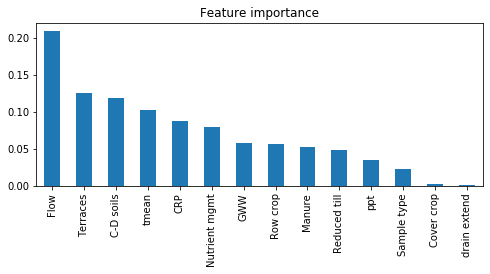

In [18]:
# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
df_merged['Sample date'] = pd.to_numeric(pd.to_datetime(df_merged['Sample date']))

# implement random forest
from sklearn.model_selection import train_test_split

# Use watershed characteristics to predict TN concentration
# other factors that can be used: seasonality, day of year, month of year, etc. 
# tried using day and month of the year as predictors - both are bad predictors
# next step: include weather data (require to be pre-processed, such as calculating daily precip, antecedent precip, etc. - need to have same length as df_nitrogen dataset)
X = df_merged[['Row crop', 'drain extend','C-D soils','Manure','Nutrient mgmt','Cover crop','Reduced till','Terraces',
                 'GWW','CRP', 'Sample type','Flow', 'ppt','tmean']]

# setting TN concentration as the "target"
y = df_merged['TN']

X_train, X_test, Y_train, Y_test = train_test_split (X, y, test_size = 0.25, random_state = 0)

reg = ske.RandomForestRegressor(n_estimators = 1000, random_state = 0)

# transform string data (i.e., site and sample type) into incremental value using label encoder
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
for i in range(len(X_train)):
    X_train[['Sample type']]= X_train[['Sample type']].apply(le.fit_transform)
    X_test[['Sample type']]= X_test[['Sample type']].apply(le.fit_transform)

reg.fit(X_train, Y_train)

Y_pred = reg.predict(X_test)

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

print('training period explained variance:', explained_variance_score(Y_test, Y_pred))
print('training period mean abs error:',mean_absolute_error(Y_test, Y_pred))
print('training period mean squared error:',mean_squared_error(Y_test, Y_pred))
print('training period r2:',r2_score(Y_test, Y_pred))

fet_ind = np.argsort(reg.feature_importances_)[::-1]
fet_imp = reg.feature_importances_[np.argsort(reg.feature_importances_)][::-1]

fig, ax = plt.subplots(1, 1, figsize=(8,3))
labels = np.asarray(X_train.columns[fet_ind])
pd.Series(fet_imp, index = labels).plot('bar', ax=ax)
ax.set_title('Feature importance')

In [19]:
#fig, ax = plt.subplots(1, 1, figsize=(8,3))
#ax.scatter(X['CRP'],y)
#ax.set_xlabel('Flow')
#ax.set_ylabel('NOx conc')

## Try to predict 2018 data, then compare against actual data

In [21]:
df_testraw = pd.read_excel('Test data 2018.xlsx', sheet_name = 'By subwatershed')

df_test = pd.merge(df_weather, df_testraw, left_on='Date', right_on='Sample date', how='right')

df_test = df_test.drop(columns=['Site', 'Sample date','Date', 'tmin', 'tmax', 'tdmean (degrees C)', 'vpdmin (hPa)', 'vpdmax (hPa)'])

# tried adding month as predictor - bad predictor
#df_test['Month'] = pd.DatetimeIndex(df_test['Sample date']).month

# convert Sample date to day of the year
# tried adding day of the year as predictor - bad predictor
# df_test['Day'] = df_test['Sample date'].dt.dayofyear

# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
#df_test['Sample date'] = pd.to_numeric(pd.to_datetime(df_test['Sample date']))

#use this to drop any predictor column that you want to exclude
#df_test = df_test.drop(columns=['Flow (cms)'])
#df_test = df_test.drop(columns=['Sample date'])

# transform string data (i.e., site and sample type) into incremental value using label encoder
le = preprocessing.LabelEncoder()
for i in range(len(df_test['Sample type'])):
    #df_test[['Site']]= df_test[['Site']].apply(le.fit_transform)
    df_test[['Sample type']]= df_test[['Sample type']].apply(le.fit_transform)
df_test.head()

,ppt,tmean,Row crop area (%),Drainage extend (%),Soils with C-D drain classes area (%),Manure application area (%),Nutrient mgmt area (%),Cover crop area (%),Reduced till area (%),Terraces area (%),GWW area (%),CRP area (%),Sample type,Flow (cms)
0,2.54,1.2,0.93,0.234,0.251,0.543494,0.272560,0.000000,0.037315,0.000823,0.044298,0.025144,0,0.034959
1,2.54,1.2,0.74,0.253,0.325,0.000000,0.805423,0.000000,0.000000,0.001710,0.000000,0.071151,0,0.022000
2,2.54,1.2,0.88,0.255,0.287,0.239038,0.058427,0.079694,0.036303,0.001148,0.010146,0.008816,0,0.075723
3,0.00,-5.3,0.93,0.234,0.251,0.543494,0.272560,0.000000,0.037315,0.000823,0.044298,0.025144,0,0.025579
4,0.00,-5.3,0.74,0.253,0.325,0.000000,0.805423,0.000000,0.000000,0.001710,0.000000,0.071151,0,0.012000


prediction period explained variance: -0.5449500512908507
prediction period mean abs error: 7.538036578808314
prediction period mean squared error: 86.88112243348858
prediction period r2: -0.6115713182632023


Text(0, 0.5, 'Predicted TN conc')

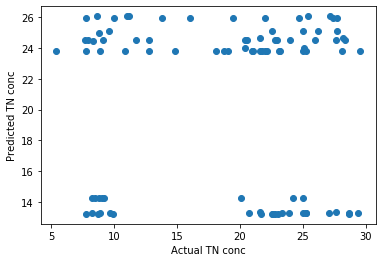

In [22]:
Y_pred = reg.predict(df_test)

df_predict = pd.DataFrame(Y_pred, columns=['TN_conc_pred'])
df_predict = pd.merge(df_testraw, df_predict, left_index=True, right_index=True)

df_actual = pd.read_excel('Test data 2018.xlsx', sheet_name = 'By subwatershed_full')
df_actual = df_actual[['Site','Sample date','Sample type', 'TN (mg N/L)']]
df_actual['day of year'] = df_actual['Sample date'].dt.dayofyear

df_predict = pd.merge(df_actual, df_predict['TN_conc_pred'], left_index=True, right_index=True)

print('prediction period explained variance:',explained_variance_score(df_predict['TN (mg N/L)'], df_predict['TN_conc_pred']))
print('prediction period mean abs error:',mean_absolute_error(df_predict['TN (mg N/L)'], df_predict['TN_conc_pred']))
print('prediction period mean squared error:',mean_squared_error(df_predict['TN (mg N/L)'], df_predict['TN_conc_pred']))
print('prediction period r2:',r2_score(df_predict['TN (mg N/L)'], df_predict['TN_conc_pred']))

plt.scatter(df_predict['TN (mg N/L)'], df_predict['TN_conc_pred'])
plt.xlabel('Actual TN conc')
plt.ylabel('Predicted TN conc')

In [23]:
writer = pd.ExcelWriter('predict_output 2018.xlsx')
# write dataframe to excel
df_predict.to_excel(writer)
# save the excel
writer.save()

## Create a dummy dataset consisting of different levels of BMPs, then use the ML model to predict nitrogen concentrations.

In [ ]:
df_testraw = pd.read_excel('Test data dummy.xlsx', sheet_name = 'Input')
df_test = df_testraw.drop(columns=['Site'])

# convert Sample date to day of the year
df_test['Day'] = df_test['Sample date'].dt.dayofyear
df_test = df_test.drop(columns=['Sample date'])

# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
#df_test['Sample date'] = pd.to_numeric(pd.to_datetime(df_test['Sample date']))

# transform string data (i.e., site and sample type) into incremental value using label encoder
le = preprocessing.LabelEncoder()
for i in range(len(df_test['Sample type'])):
    #df_test[['Site']]= df_test[['Site']].apply(le.fit_transform)
    df_test[['Sample type']]= df_test[['Sample type']].apply(le.fit_transform)
#df_test.head()

In [ ]:
Y_pred = reg.predict(df_test)

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

fet_ind = np.argsort(reg.feature_importances_)[::-1]
fet_imp = reg.feature_importances_[np.argsort(reg.feature_importances_)][::-1]

fig, ax = plt.subplots(1, 1, figsize=(8,3))
labels = np.asarray(X_train.columns[fet_ind])
pd.Series(fet_imp, index = labels).plot('bar', ax=ax)
ax.set_title('Feature importance')

In [ ]:
df_predict = pd.DataFrame(Y_pred, columns=['TN_conc_pred'])
df_predict = pd.merge(df_testraw, df_predict, left_index=True, right_index=True)

writer = pd.ExcelWriter('predict_output.xlsx')
# write dataframe to excel
df_predict.to_excel(writer)
# save the excel
writer.save()

### Model 2 - mpact of precipitation on flow and nitrogen concentration

In [ ]:
#df_weather.head()

In [ ]:
#df_weather['Year'], df_weather['Month'],df_weather['Day'] = df_weather['Date'].dt.year, df_weather['Date'].dt.month, df_weather['Date'].dt.day
#df_weather.head()